Time Series Data Imputation with GANs
=============

By Sohaib Errabii, Mael Lucas

Introduction
------------

This notebook is devoted to the investigation of different GAN based methods for time series imputation.


In [1]:
import random
import numpy as np
from typing import Tuple
import torch
import torch.nn as nn
from torch import Tensor
from torch.utils.data import DataLoader, TensorDataset
from datasets import UCIHAR
import matplotlib.pyplot as plt
from utils import imputation_rmse

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
np.random.seed(manualSeed)
torch.manual_seed(manualSeed);

Random Seed:  999


Inputs
------

Let’s define some inputs for the run:

In [2]:
# Root directory of datasets
root = "data"

# Rate of the missing data
miss_rate = 0.2

# Number of workers for dataloader
workers = 2

# Hidden size of GRU
hz = 64

# Batch size during training/testing
batch_size = 128

# Number of training epochs for imputation model
num_epochs = 40

# Number of training epochs for the classifier
cls_epochs = 200

# Learning rate for optimizers
lr = 0.005

# Generator MSELoss multiplier
alpha = 100

Data
----

We will use the **UCI-HAR** Dataset <https://archive.ics.uci.edu/ml/datasets/human+activity+recognition+using+smartphones>. 



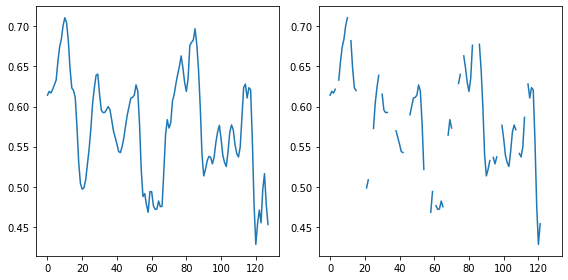

In [3]:
# Create the datasets
ucihar = UCIHAR(root_dir=root, download=True)
ucihar_test = UCIHAR(root_dir=root, train=False)
ucihar_miss = UCIHAR(root_dir=root, miss_rate=miss_rate)

# Create the dataloaders
dataloader = DataLoader(ucihar, batch_size=batch_size, num_workers=workers)
dataloader_test = DataLoader(ucihar_test, batch_size=batch_size, num_workers=workers)
dataloader_miss = DataLoader(ucihar_miss, batch_size=batch_size, num_workers=workers)

# Define UCI-HAR parameters
n_samples, n_timesteps, n_features = ucihar.data.shape
n_classes = len(ucihar.labels)

# Plot some signal before/after amputation
signal_id = random.randrange(n_features)
sample_id = random.randrange(n_samples)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))
axes[0].plot(ucihar.data[sample_id, :, signal_id])
axes[1].plot(ucihar_miss.data[sample_id, :, signal_id])
fig.tight_layout()

# TODO: improve data missingness simulation (something more sequential but controllable with miss_rate)

Model
--------------

We start with a simple GAN model, where the generator and discriminator
are instances of the following GRU-based model.

In [4]:
class GRUPlusFC(nn.Module):
    def __init__(
        self, sequence_length, input_size, 
        hidden_size , output_size, last_only=False):
        super().__init__()
        self.sequence_length = sequence_length
        self.hidden_size = hidden_size
        self.last_only = last_only
        self.gru = nn.GRU(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        output, _ = self.gru(x, self._init_hidden(x.size(0)))
        output = self.fc(nn.ReLU(True)(output))
        if self.last_only:
            return output[:, -1]
        else:
            return nn.Sigmoid()(output)
    
    def _init_hidden(self, batch_size):
        return torch.zeros(1, batch_size, self.hidden_size)


def generator_loss(
        x: Tensor, x_hat: Tensor,
        mask: Tensor, d_x: Tensor) -> Tuple[Tensor, Tensor]:
    return (nn.MSELoss()(mask * x, mask * x_hat) / torch.mean(mask.float()),
           torch.mean(~mask * torch.log(torch.add(d_x, 1e-8)))
    )

In [5]:
# Generator & Discriminator
netG = GRUPlusFC(n_timesteps, n_features, hz, n_features)
netD = GRUPlusFC(n_timesteps, n_features, hz, n_features)

# Loss functions
criterionG = generator_loss
criterionD = nn.BCELoss()

# Optimizers
optimizerG = torch.optim.Adam(netG.parameters(), lr=lr)
optimizerD = torch.optim.Adam(netD.parameters(), lr=lr)

Training
--------------

In [6]:
# Training Loop

# Lists to keep track of progress
lossesG = []
lossesD = []

for epoch in range(num_epochs):
    for i, (data, _) in enumerate(dataloader_miss):
        # Sample random noise
        z = torch.rand(data.shape) * 0.01
        
        # Get binary mask from data, mask = 1 if observed
        mask = ~torch.isnan(data)
        
        # Combine random noise with observed data
        data = mask * torch.nan_to_num(data) + ~mask * z
        
        ###################################
        # (1) Update D: minimize BCE(M, D(G(x)))
        ###################################
        netD.zero_grad()
        
        # Generate imputed data with G
        dataG = netG(data)
        
        # Classify imputed data with D
        data_imp = mask * data + ~mask * dataG
        probD = netD(data_imp.detach())
        
        # Compute loss for D
        lossD = criterionD(probD, mask.float())
        # Compute gradients for D
        lossD.backward()
        # Update D
        optimizerD.step()
        
        ###################################
        # (2) Update G: minimize MSE(M * x, M * G(x)) - (1 - M) * log(D(G(x))
        ###################################
        netG.zero_grad()
        
        # Classify imputed data once more since D got updated
        probD = netD(data_imp)
                
        # Compute loss for G
        loss_rec, loss_adv = criterionG(data, dataG, mask, probD)
        lossG = alpha * loss_rec - loss_adv
        # Compute gradients for G
        lossG.backward()
        # Update G
        optimizerG.step()
        
        # Output training stats
        if i % 50 == 0:
            print(
                f"[{epoch}/{num_epochs}][{i}/{len(dataloader)}]\t"
                f"LossD: {lossD.item():04f}\tLossG_rec: {loss_rec.item():04f}"
                f"\tLossG_adv: {-loss_adv.item():04f}"
            )

        # Save Losses for plotting later
        lossesG.append(lossG.item())
        lossesD.append(lossD.item())

[0/40][0/58]	LossD: 0.690407	LossG_rec: 0.011181	LossG_adv: 0.132039
[0/40][50/58]	LossD: 0.500196	LossG_rec: 0.005407	LossG_adv: 0.043883
[1/40][0/58]	LossD: 0.501029	LossG_rec: 0.003104	LossG_adv: 0.045268
[1/40][50/58]	LossD: 0.499936	LossG_rec: 0.004417	LossG_adv: 0.044735
[2/40][0/58]	LossD: 0.500747	LossG_rec: 0.002873	LossG_adv: 0.044882
[2/40][50/58]	LossD: 0.499613	LossG_rec: 0.003429	LossG_adv: 0.044807
[3/40][0/58]	LossD: 0.500312	LossG_rec: 0.002348	LossG_adv: 0.044871
[3/40][50/58]	LossD: 0.497158	LossG_rec: 0.002284	LossG_adv: 0.045379
[4/40][0/58]	LossD: 0.497055	LossG_rec: 0.001809	LossG_adv: 0.045553
[4/40][50/58]	LossD: 0.481188	LossG_rec: 0.001448	LossG_adv: 0.049452
[5/40][0/58]	LossD: 0.478873	LossG_rec: 0.001270	LossG_adv: 0.050301
[5/40][50/58]	LossD: 0.446527	LossG_rec: 0.000893	LossG_adv: 0.060583
[6/40][0/58]	LossD: 0.441210	LossG_rec: 0.000928	LossG_adv: 0.062475
[6/40][50/58]	LossD: 0.406580	LossG_rec: 0.000556	LossG_adv: 0.081316
[7/40][0/58]	LossD: 0.39599

## Results


### Loss versus training iteration

Below is a plot of D & G’s losses versus training iterations.

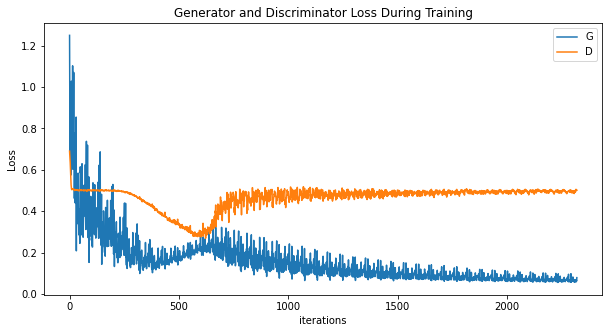

In [7]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(lossesG, label="G")
plt.plot(lossesD, label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

### Imputation

We now impute the data and save it in `x_imputed`. We can also evaluate the quality
of the imputation with the root mean square error.

**Remark:** The **rmse** metric by itself is not very useful, but it will be used compare against _improved_ versions of the GAN-based model or other imputation methods (MissForest, MICE, $\dots$).

RMSE Performance: 0.05120026137066309


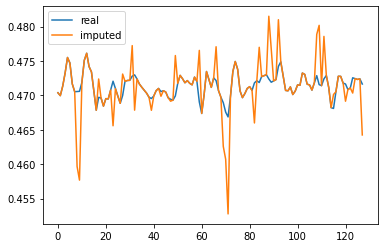

In [8]:
# We impute the whole dataset at once
with torch.no_grad():
    # Complete data
    x_complete = ucihar.data

    # Impute the missing data
    x_miss = ucihar_miss.data
    z = torch.rand(x_miss.shape) * 0.01
    mask = ~torch.isnan(x_miss)
    x_noised = mask * torch.nan_to_num(x_miss) + ~mask * z
    xG = netG(x_noised)
    x_imputed = mask * x_noised + ~mask * xG

    # RMSE performance
    rmse = imputation_rmse(x_complete.numpy(), xG.numpy(), mask.numpy())
    print(f"RMSE Performance: {rmse}")

    # Plot some signal before/after imputation
    signal_id = random.randrange(n_features)
    sample_id = random.randrange(n_samples)
    plt.plot(x_complete[sample_id, :, signal_id], label="real")
    plt.plot(x_imputed[sample_id, :, signal_id], label="imputed")
    plt.legend()

### Performance Comparison for Classification Task

We compare the test accuracy obtained by training a classifier on the complete
dataset, mean imputation and our GAN-based imputation.

For the classifier, we use the model `GRUPlusFC`.

In [10]:
def train(model, loader, optimizer):
    loss_epoch = 0
    accuracy_epoch = 0

    for i, (x, y) in enumerate(loader):
        optimizer.zero_grad()
        output = model(x)
        loss = nn.CrossEntropyLoss()(output, y)
        
        predicted = output.argmax(1)
        acc = (predicted == y).sum().item() / y.size(0)
        accuracy_epoch += acc
        
        loss.backward()
        optimizer.step()

        loss_epoch += loss.item()
        # if i % 50 == 0:
        #     print(
        #         f"Step [{i}/{len(loader)}]\t Loss: {loss.item()}\t Accuracy: {acc}"
        #     )
    return loss_epoch / len(loader), accuracy_epoch / len(loader)


def test(model, loader):
    model.eval()
    accuracy_epoch = 0
    for i, (x, y) in enumerate(loader):
        # Classify batch with model
        output = model(x)

        # Compute batch accuracy
        predicted = output.argmax(1)
        acc= (predicted == y).sum().item() / y.size(0)
        accuracy_epoch += acc
           
    return accuracy_epoch / len(loader)

#### Training the classifier on the GAN-imputed dataset

First, we train the classifier on the imputed data `x_imputed` (computed above for **rmse**) and save the test accuracy obtained every
$20$ epochs in the list `test_accuracies`.

In [12]:
# Classifier model
cls = GRUPlusFC(n_timesteps, n_features, hz, n_classes, last_only=True)

# Optimizer
optimizer = torch.optim.Adam(cls.parameters(), lr=lr)

# Create loader for imputed data
dataloader_imp = DataLoader(
    TensorDataset(x_imputed, ucihar.targets),
    batch_size=batch_size, 
    num_workers=workers
)

# Train the classifier on the imputed dataset
test_accuracies = []
for epoch in range(cls_epochs):
    # Train
    loss_epoch, accuracy_epoch = train(cls, dataloader_imp, optimizer)
    
    print(f"Epoch [{epoch}/{cls_epochs}]\t Loss: {loss_epoch}\t Train Accuracy: {accuracy_epoch}")
    
    # Test
    if (epoch + 1) % 20 == 0:
        acc = test(cls, dataloader_test)
        test_accuracies.append(acc)

Epoch [0/200]	 Loss: 1.6259474569353565	 Accuracy: 0.30886314655172414
Epoch [1/200]	 Loss: 1.6626972720540802	 Accuracy: 0.3323583743842365
Epoch [2/200]	 Loss: 1.5776348956700028	 Accuracy: 0.32408405172413796
Epoch [3/200]	 Loss: 1.438381971984074	 Accuracy: 0.3911637931034483
Epoch [4/200]	 Loss: 1.3221474937323867	 Accuracy: 0.40651939655172414
Epoch [5/200]	 Loss: 1.3559698945489422	 Accuracy: 0.38698814655172414
Epoch [6/200]	 Loss: 1.36613303936761	 Accuracy: 0.38348599137931033
Epoch [7/200]	 Loss: 1.345471793207629	 Accuracy: 0.3929148706896552
Epoch [8/200]	 Loss: 1.312615439809602	 Accuracy: 0.41877693965517243
Epoch [9/200]	 Loss: 1.278970686526134	 Accuracy: 0.4175646551724138
Epoch [10/200]	 Loss: 1.2253606237214187	 Accuracy: 0.4847790948275862
Epoch [11/200]	 Loss: 1.2828119808229907	 Accuracy: 0.44361915024630544
Epoch [12/200]	 Loss: 0.9980910975357582	 Accuracy: 0.5945581896551724
Epoch [13/200]	 Loss: 0.7975133236112266	 Accuracy: 0.6512276785714285
Epoch [14/200]	

Epoch [115/200]	 Loss: 0.12644869562540534	 Accuracy: 0.9469288793103449
Epoch [116/200]	 Loss: 0.1268624388705638	 Accuracy: 0.9478717672413793
Epoch [117/200]	 Loss: 0.11636494614504045	 Accuracy: 0.951239224137931
Epoch [118/200]	 Loss: 0.11424991082320299	 Accuracy: 0.9516433189655172
Epoch [119/200]	 Loss: 0.11471380231862362	 Accuracy: 0.9513739224137931
Epoch [120/200]	 Loss: 0.11872627270926826	 Accuracy: 0.9476023706896551
Epoch [121/200]	 Loss: 0.11817426402382714	 Accuracy: 0.9502963362068966
Epoch [122/200]	 Loss: 0.11678970129450418	 Accuracy: 0.9517780172413793
Epoch [123/200]	 Loss: 0.11518148689293443	 Accuracy: 0.9521821120689655
Epoch [124/200]	 Loss: 0.11483207019710821	 Accuracy: 0.9521821120689655
Epoch [125/200]	 Loss: 0.11542483240053367	 Accuracy: 0.9520474137931034
Epoch [126/200]	 Loss: 0.11364217791209551	 Accuracy: 0.9527209051724138
Epoch [127/200]	 Loss: 0.1194235531091118	 Accuracy: 0.9508351293103449
Epoch [128/200]	 Loss: 0.11860661730880283	 Accuracy: 

#### Training the classifier on the original dataset 

Next we can train the classifier on the real/observed dataset and save the test accuracies in `test_accuracies_complete`.

In [13]:
# Classifier model
cls = GRUPlusFC(n_timesteps, n_features, hz, n_classes, last_only=True)

# Optimizers
optimizer = torch.optim.Adam(cls.parameters(), lr=lr)

test_accuracies_complete = []

for epoch in range(cls_epochs):
    # Train
    loss_epoch, accuracy_epoch = train(cls, dataloader, optimizer)
    
    print(f"Epoch [{epoch}/{cls_epochs}]\t Loss: {loss_epoch}\t Train Accuracy: {accuracy_epoch}")
    
    # Test
    if (epoch + 1) % 20 == 0:
        acc = test(cls, dataloader_test)
        test_accuracies_complete.append(acc)

Epoch [0/200]	 Loss: 1.578501834951598	 Accuracy: 0.33014547413793105
Epoch [1/200]	 Loss: 1.406370393161116	 Accuracy: 0.3572198275862069
Epoch [2/200]	 Loss: 1.7271561437639698	 Accuracy: 0.2830010775862069
Epoch [3/200]	 Loss: 1.4290773848007465	 Accuracy: 0.3527747844827586
Epoch [4/200]	 Loss: 1.625540316104889	 Accuracy: 0.31573275862068967
Epoch [5/200]	 Loss: 1.279549358219936	 Accuracy: 0.4580895935960591
Epoch [6/200]	 Loss: 1.1995288020577923	 Accuracy: 0.5137584667487685
Epoch [7/200]	 Loss: 0.9213125942082241	 Accuracy: 0.5966941194581281
Epoch [8/200]	 Loss: 0.7829822527951208	 Accuracy: 0.6696813423645319
Epoch [9/200]	 Loss: 0.6393942370496947	 Accuracy: 0.7065309421182266
Epoch [10/200]	 Loss: 0.553326236276791	 Accuracy: 0.7485375615763546
Epoch [11/200]	 Loss: 0.6092471413571259	 Accuracy: 0.7234644396551724
Epoch [12/200]	 Loss: 0.5723860299792783	 Accuracy: 0.7363185036945813
Epoch [13/200]	 Loss: 0.49381122917964543	 Accuracy: 0.7792487684729064
Epoch [14/200]	 Lo

Epoch [115/200]	 Loss: 0.12210070045367846	 Accuracy: 0.9461206896551724
Epoch [116/200]	 Loss: 0.12169194895752047	 Accuracy: 0.9521821120689655
Epoch [117/200]	 Loss: 0.12236049806961091	 Accuracy: 0.9486799568965517
Epoch [118/200]	 Loss: 0.1173000292275964	 Accuracy: 0.955145474137931
Epoch [119/200]	 Loss: 0.1409822618522318	 Accuracy: 0.9465247844827587
Epoch [120/200]	 Loss: 0.15709247326745315	 Accuracy: 0.9410021551724138
Epoch [121/200]	 Loss: 0.13366262429165013	 Accuracy: 0.9466594827586207
Epoch [122/200]	 Loss: 0.12488708235594395	 Accuracy: 0.9497575431034483
Epoch [123/200]	 Loss: 0.12162496222199165	 Accuracy: 0.9556842672413793
Epoch [124/200]	 Loss: 0.12093511043838526	 Accuracy: 0.9539331896551724
Epoch [125/200]	 Loss: 0.12436676211366611	 Accuracy: 0.9489493534482759
Epoch [126/200]	 Loss: 0.14439709557938904	 Accuracy: 0.9410021551724138
Epoch [127/200]	 Loss: 0.14888451869272354	 Accuracy: 0.9389816810344828
Epoch [128/200]	 Loss: 0.1707386478805786	 Accuracy: 0

#### Training the classifier on a mean-imputed dataset

Finally, for the sake of comparaison we also train the classifier on the dataset that is imputed using the **mean**
of every time window (sequence of length $128$). The test accuracies obtained every $20$ epochs are saved in `test_accuracies_mean`.

In [14]:
# Mean imputation
with torch.no_grad():
    x_miss = ucihar_miss.data
    x_mean = torch.nanmean(x_miss, dim=1, keepdim=True)
    mask = ~torch.isnan(x_miss)
    x_imputed_mean = mask * torch.nan_to_num(x_miss) + ~mask * x_mean

# Dataloader for mean imputed UCI-HAR
dataloader_mean = DataLoader(
    TensorDataset(x_imputed_mean, ucihar.targets),
    batch_size=batch_size, 
    num_workers=workers
)

# Classifier model
cls = GRUPlusFC(n_timesteps, n_features, hz, n_classes, last_only=True)

# Optimizers
optimizer = torch.optim.Adam(cls.parameters(), lr=lr)

test_accuracies_mean = []

for epoch in range(cls_epochs):
    # Train
    loss_epoch, accuracy_epoch = train(cls, dataloader_mean, optimizer)
    
    print(f"Epoch [{epoch}/{cls_epochs}]\t Loss: {loss_epoch}\t Train Accuracy: {accuracy_epoch}")
    
    # Test
    if (epoch + 1) % 20 == 0:
        acc = test(cls, dataloader_test)
        test_accuracies_mean.append(acc)

Epoch [0/200]	 Loss: 1.6400066244191136	 Accuracy: 0.3125
Epoch [1/200]	 Loss: 1.6845174164607608	 Accuracy: 0.26980064655172414
Epoch [2/200]	 Loss: 1.6412511961213474	 Accuracy: 0.27599676724137934
Epoch [3/200]	 Loss: 1.6161196684015209	 Accuracy: 0.34388469827586204
Epoch [4/200]	 Loss: 1.414065069165723	 Accuracy: 0.35223599137931033
Epoch [5/200]	 Loss: 1.308890529747667	 Accuracy: 0.42591594827586204
Epoch [6/200]	 Loss: 1.2644126322762719	 Accuracy: 0.41369689039408863
Epoch [7/200]	 Loss: 1.2340214848518372	 Accuracy: 0.4167564655172414
Epoch [8/200]	 Loss: 1.2469359173856933	 Accuracy: 0.4507774014778325
Epoch [9/200]	 Loss: 1.2068988711669528	 Accuracy: 0.47879464285714285
Epoch [10/200]	 Loss: 1.1932217941201966	 Accuracy: 0.4408866995073892
Epoch [11/200]	 Loss: 1.74565300859254	 Accuracy: 0.3036099137931034
Epoch [12/200]	 Loss: 1.4353326744046704	 Accuracy: 0.3410560344827586
Epoch [13/200]	 Loss: 1.3252500501172295	 Accuracy: 0.3902209051724138
Epoch [14/200]	 Loss: 1.3

Epoch [116/200]	 Loss: 0.2869416170207591	 Accuracy: 0.8896436268472906
Epoch [117/200]	 Loss: 0.2847196139266779	 Accuracy: 0.8878925492610837
Epoch [118/200]	 Loss: 0.28017819576479236	 Accuracy: 0.8920681958128078
Epoch [119/200]	 Loss: 0.2830334287136793	 Accuracy: 0.8884313423645319
Epoch [120/200]	 Loss: 0.27991431842333286	 Accuracy: 0.8905865147783251
Epoch [121/200]	 Loss: 0.27173152520995714	 Accuracy: 0.894223368226601
Epoch [122/200]	 Loss: 0.26912851316918585	 Accuracy: 0.8937230603448276
Epoch [123/200]	 Loss: 0.27394199647523204	 Accuracy: 0.8933189655172413
Epoch [124/200]	 Loss: 0.2753849086704953	 Accuracy: 0.8899130233990147
Epoch [125/200]	 Loss: 0.2588258586695482	 Accuracy: 0.8993419027093595
Epoch [126/200]	 Loss: 0.2551807518406161	 Accuracy: 0.9019011699507389
Epoch [127/200]	 Loss: 0.2533100177373352	 Accuracy: 0.90159328817734
Epoch [128/200]	 Loss: 0.25389545320950707	 Accuracy: 0.9040563423645319
Epoch [129/200]	 Loss: 0.2452127148622069	 Accuracy: 0.909848

#### Comparaison of test accuracy

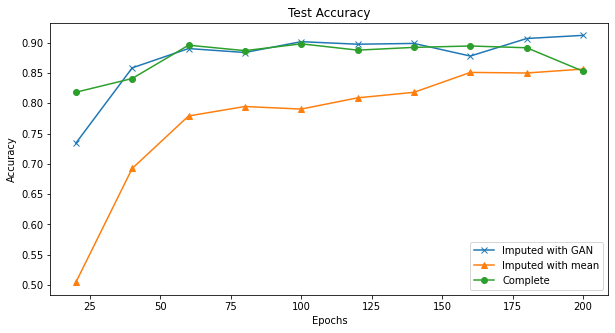

In [15]:
# Plot test accuracy
plt.figure(figsize=(10,5))
plt.title("Test Accuracy")
plt.plot(np.arange(20, cls_epochs + 1, 20), test_accuracies, marker='x', label='Imputed with GAN')
plt.plot(np.arange(20, cls_epochs + 1, 20), test_accuracies_mean, marker='^', label='Imputed with mean')
plt.plot(np.arange(20, cls_epochs + 1, 20), test_accuracies_complete, marker='o', label='Complete')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()